# <center>Telecom Churn Group Case Study<br/>By: Toan Nguyen</center>

## Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business goal.

To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.

In this project, you will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

## High-value churn

In the Indian and the Southeast Asian market, approximately 80% of revenue comes from the top 20% customers (called high-value customers). Thus, if we can reduce churn of the high-value customers, we will be able to reduce significant revenue leakage.

 
In this project, you will define high-value customers based on a certain metric (mentioned later below) and predict churn only on high-value customers.

## Understanding the business objective and the data

The dataset contains customer-level information for a span of four consecutive months - June, July, August and September. The months are encoded as 6, 7, 8 and 9, respectively. 


The business objective is to predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months. To do this task well, understanding the typical customer behaviour during churn will be helpful.

## Definitions of churn

There are various ways to define churn, such as:

* <strong>Revenue-based churn:</strong> Customers who have not utilised any revenue-generating facilities such as mobile internet, outgoing calls, SMS etc. over a given period of time. One could also use aggregate metrics such as ‘customers who have generated less than INR 4 per month in total/average/median revenue’.

    The main shortcoming of this definition is that there are customers who only receive calls/SMSes from their wage-earning counterparts, i.e. they don’t generate revenue but use the services. For example, many users in rural areas only receive calls from their wage-earning siblings in urban areas.
    

* <strong>Usage-based churn:</strong> Customers who have not done any usage, either incoming or outgoing - in terms of calls, internet etc. over a period of time.

    A potential shortcoming of this definition is that when the customer has stopped using the services for a while, it may be too late to take any corrective actions to retain them. For e.g., if you define churn based on a ‘two-months zero usage’ period, predicting churn could be useless since by that time the customer would have already switched to another operator.

In this project, <strong>you will use the usage-based definition to define churn.</strong>

## Understanding customer behaviour during churn

Customers usually do not decide to switch to another competitor instantly, but rather over a period of time (this is especially applicable to high-value customers). In churn prediction, we assume that there are three phases of customer lifecycle :

* <strong>The ‘good’ phase:</strong> In this phase, the customer is happy with the service and behaves as usual.

* <strong>The ‘action’ phase:</strong> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a  competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. Also, it is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

* <strong>The ‘churn’ phase:</strong> In this phase, the customer is said to have churned. You define churn based on this phase. Also, it is important to note that at the time of prediction (i.e. the action months), this data is not available to you for prediction. Thus, after tagging churn as 1/0 based on this phase, you discard all data corresponding to this phase.

In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month is the ‘churn’ phase.

## Approach

We will approach the problem in the following steps

* General data understanding
* Data preparation
    * Data preprocessing
    * Deriving features
    * Filtering high value customers
    * Tagging churners

* Exploratory Data Analysis

* Model building
* Insights and Recommendations

## I. General data understanding

In [1]:
# Importing initial required libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Make pandas show all columns and rows instead of collapsing to ...
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# read the data into df variable
filename = 'telecom_churn_data.csv'
df = pd.read_csv(filename)
df.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,0.00,0.00,5.44,0.00,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,4,3,

In [4]:
df.shape

(99999, 226)

We can notice the following:
* Most columns contain numeric data.
* Some contain datetime data, which is essentially also numeric.
* Data can grouped into months: 6, 7, 8, 9.
* The data set contains quite a large amount of data: 99,999 rows in 226 columns.

## II. Data preparation

### II.1 Data preprocessing:

#### II.1.1 Correcting data types

The first step is to convert data to the right formats.

In [5]:
# Converting datas to datetime format
date_cols = df.columns[df.columns.str.contains('date')]
date_cols

Index(['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'last_date_of_month_9', 'date_of_last_rech_6', 'date_of_last_rech_7',
       'date_of_last_rech_8', 'date_of_last_rech_9',
       'date_of_last_rech_data_6', 'date_of_last_rech_data_7',
       'date_of_last_rech_data_8', 'date_of_last_rech_data_9'],
      dtype='object')

In [6]:
df[date_cols].head()

,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9
0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/21/2014,7/16/2014,8/8/2014,9/28/2014,6/21/2014,7/16/2014,8/8/2014,NaN
1,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/29/2014,7/31/2014,8/28/2014,9/30/2014,NaN,7/25/2014,8/10/2014,NaN
2,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/17/2014,7/24/2014,8/14/2014,9/29/2014,NaN,NaN,NaN,9/17/2014
3,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/28/2014,7/31/2014,8/31/2014,9/30/2014,NaN,NaN,NaN,NaN
4,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/26/2014,7/28/2014,8/9/2014,9/28/2014,6/4/2014,NaN,NaN,NaN


We can see that these dates are in the format '%m/%d/%Y'. Let's convert them to datetime format

In [7]:
# Let's convert these columns to datetime
for col in date_cols:
    df[col] = pd.to_datetime(df[col])

#### II.1.2 Dropping single unique columns and other unnecessary columns

In [8]:
# Firstly, let drop mobile number as it doesn't help in our classification job at hand
df.drop('mobile_number', axis=1, inplace = True)

In [9]:
# Next, can drop signle-value columns as they do help in our classification job either
# Checking for single unique value columns
nunique_cols = []
for col in df.columns:
    if df[col].nunique() == 1:
        nunique_cols.append(col)
nunique_cols

['circle_id',
 'loc_og_t2o_mou',
 'std_og_t2o_mou',
 'loc_ic_t2o_mou',
 'last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'last_date_of_month_9',
 'std_og_t2c_mou_6',
 'std_og_t2c_mou_7',
 'std_og_t2c_mou_8',
 'std_og_t2c_mou_9',
 'std_ic_t2o_mou_6',
 'std_ic_t2o_mou_7',
 'std_ic_t2o_mou_8',
 'std_ic_t2o_mou_9']

In [10]:
for col in nunique_cols:
    print(df[col].value_counts())

109    99999
Name: circle_id, dtype: int64
0.0    98981
Name: loc_og_t2o_mou, dtype: int64
0.0    98981
Name: std_og_t2o_mou, dtype: int64
0.0    98981
Name: loc_ic_t2o_mou, dtype: int64
2014-06-30    99999
Name: last_date_of_month_6, dtype: int64
2014-07-31    99398
Name: last_date_of_month_7, dtype: int64
2014-08-31    98899
Name: last_date_of_month_8, dtype: int64
2014-09-30    98340
Name: last_date_of_month_9, dtype: int64
0.0    96062
Name: std_og_t2c_mou_6, dtype: int64
0.0    96140
Name: std_og_t2c_mou_7, dtype: int64
0.0    94621
Name: std_og_t2c_mou_8, dtype: int64
0.0    92254
Name: std_og_t2c_mou_9, dtype: int64
0.0    96062
Name: std_ic_t2o_mou_6, dtype: int64
0.0    96140
Name: std_ic_t2o_mou_7, dtype: int64
0.0    94621
Name: std_ic_t2o_mou_8, dtype: int64
0.0    92254
Name: std_ic_t2o_mou_9, dtype: int64


In [11]:
# Dropping single-value columns
df.drop(nunique_cols, axis=1, inplace = True)
df.shape

(99999, 209)

We can see that the number of columns has reduced from 226 to 209.

### II.2 Deriving features and filtering high-value customers

As the analysis is focused on high-value customers only, we should filter out these customers early on and conduct analysis on these customers. 

High value customers are defined as those whose have average revenue > 70 percentile value. So, to proceed, we have to derive a feature to help us filter out high-value customers first. 

#### II.2.1 Average good-phase revenues

As high-value customers are defined based on the <strong>average revenue</strong> they generated for the company through their usage of the company's services in the good phase, we need to define this feature. <strong>Average revenue</strong> is the average of:
* data rechargge amount and 
* total call / sms recharge (total_rech_amt_x) 

in month 6 and 7.

Firstly, let's derive a feature representing the <strong>total data recharge amount</strong>, which can be calculated as the product of <strong>average recharge amount x total recharge data<strong>
#### <center>total_rech_amt_data_x = av_rech_amt_data_x * total_rech_data_x</center>
where x is the recharging month.

In [12]:
# Getting a list of recharge-related columns 
rech_cols =  df.columns[df.columns.str.contains('rech')]
print(rech_cols)

Index(['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8',
       'total_rech_num_9', 'total_rech_amt_6', 'total_rech_amt_7',
       'total_rech_amt_8', 'total_rech_amt_9', 'max_rech_amt_6',
       'max_rech_amt_7', 'max_rech_amt_8', 'max_rech_amt_9',
       'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8',
       'date_of_last_rech_9', 'date_of_last_rech_data_6',
       'date_of_last_rech_data_7', 'date_of_last_rech_data_8',
       'date_of_last_rech_data_9', 'total_rech_data_6', 'total_rech_data_7',
       'total_rech_data_8', 'total_rech_data_9', 'max_rech_data_6',
       'max_rech_data_7', 'max_rech_data_8', 'max_rech_data_9',
       'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8',
       'count_rech_2g_9', 'count_rech_3g_6', 'count_rech_3g_7',
       'count_rech_3g_8', 'count_rech_3g_9', 'av_rech_amt_data_6',
       'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9'],
      dtype='object')


We can see that the information contained in these columns include:
* Total recharge amount (total_rech_amt_x)
* Total data recharge amount (total_rech_amt_x)
* Max data recharge amount (max_rech_amt_x)
* Date of last recharge (date_of_last_rech_x)
* Max recharge data (max_rech_data_x)
* Count of 2g and 3g recharge

In [13]:
# Checking for null values among recharge columns
df[rech_cols].isnull().sum() * 100 / df.shape[0]

total_rech_num_6             0.000000
total_rech_num_7             0.000000
total_rech_num_8             0.000000
total_rech_num_9             0.000000
total_rech_amt_6             0.000000
total_rech_amt_7             0.000000
total_rech_amt_8             0.000000
total_rech_amt_9             0.000000
max_rech_amt_6               0.000000
max_rech_amt_7               0.000000
max_rech_amt_8               0.000000
max_rech_amt_9               0.000000
date_of_last_rech_6          1.607016
date_of_last_rech_7          1.767018
date_of_last_rech_8          3.622036
date_of_last_rech_9          4.760048
date_of_last_rech_data_6    74.846748
date_of_last_rech_data_7    74.428744
date_of_last_rech_data_8    73.660737
date_of_last_rech_data_9    74.077741
total_rech_data_6           74.846748
total_rech_data_7           74.428744
total_rech_data_8           73.660737
total_rech_data_9           74.077741
max_rech_data_6             74.846748
max_rech_data_7             74.428744
max_rech_dat

We can see that the percentage of null values in many columns are quite high, around 74%.

In [14]:
df[rech_cols].describe()

,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9
count,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,25153.000000,25571.000000,26339.000000,25922.000000,25153.000000,25571.000000,26339.000000,25922.00000,25153.000000,25571.000000,26339.000000,25922.000000,25153.000000,25571.000000,26339.000000,25922.000000,25153.000000,25571.000000,26339.000000,25922.000000
mean,7.558806,7.700367,7.212912,6.893019,327.514615,322.962970,324.157122,303.345673,104.637486,104.752398,107.728207,101.943889,2.463802,2.666419,2.651999,2.441170,126.393392,126.729459,125.717301,124.94144,1.864668,2.044699,2.016288,1.781807,0.599133,0.621720,0.635711,0.659363,192.600982,200.981292,197.526489,192.734315
std,7.078405,7.070422,7.203753,7.096261,398.019701,408.114237,416.540455,404.588583,120.614894,124.523970,126.902505,125.375109,2.789128,3.031593,3.074987,2.516339,108.477235,109.765267,109.437851,111.36376,2.570254,2.768332,2.720132,2.214701,1.274428,1.394524,1.422827,1.411513,192.646318,196.791224,191.301305,188.400286
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.500000,0.500000,1.000000
25%,3.000000,3.000000,3.000000,3.000000,109.000000,100.000000,90.000000,52.000000,30.000000,30.000000,30.000000,28.000000,1.000000,1.000000,1.000000,1.000000,25.000000,25.000000,25.000000,25.00000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,82.000000,92.000000,87.000000,69.000000
50%,6.000000,6.000000,5.000000,5.000000,230.000000,220.000000,225.000000,200.000000,110.000000,110.000000,98.000000,61.000000,1.000000,1.000000,1.000000,2.000000,145.000000,145.000000,145.000000,145.00000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,154.000000,154.000000,154.000000,164.000000
75%,9.000000,10.000000,9.000000,9.000000,437.500000,428.000000,434.500000,415.000000,120.000000,128.000000,144.000000,144.000000,3.000000,3.000000,3.000000,3.000000,177.000000,177.000000,179.000000,179.00000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,252.000000,252.000000,252.000000,252.000000
max,307.000000,138.000000,196.000000,131.000000,35190.000000,40335.000000,45320.000000,37235.000000,4010.000000,4010.000000,4449.000000,3399.000000,61.000000,54.000000,60.000000,84.000000,1555.000000,1555.000000,1555.000000,1555.00000,42.000000,48.000000,44.000000,40.000000,29.000000,35.000000,45.000000,49.000000,7546.000000,4365.000000,4076.000000,4061.000000


We can see that the minimum amount of recharge is 1. So, null values in recharge columns can be imputed by 0.

In [15]:
df['total_rech_amt_6'] = df['total_rech_amt_6'].fillna(0) 
df['total_rech_amt_7'] = df['total_rech_amt_7'].fillna(0) 
df['total_rech_amt_8'] = df['total_rech_amt_8'].fillna(0) 

df['total_rech_data_6'] = df['total_rech_data_6'].fillna(0)
df['total_rech_data_7'] = df['total_rech_data_7'].fillna(0)
df['total_rech_data_8'] = df['total_rech_data_8'].fillna(0)

df['av_rech_amt_data_6'] = df['av_rech_amt_data_6'].fillna(0) 
df['av_rech_amt_data_7'] = df['av_rech_amt_data_7'].fillna(0) 
df['av_rech_amt_data_8'] = df['av_rech_amt_data_8'].fillna(0) 

In [16]:
# Defining data recharge amount
df['total_rech_amt_data_6'] = df['av_rech_amt_data_6'] * df['total_rech_data_6']
df['total_rech_amt_data_7'] = df['av_rech_amt_data_7'] * df['total_rech_data_7']
df['total_rech_amt_data_8'] = df['av_rech_amt_data_8'] * df['total_rech_data_8']
df['total_rech_amt_data_9'] = df['av_rech_amt_data_9'] * df['total_rech_data_9']

In [17]:
# Now that we have the total data recharge amount, we can drop the columns which have been accounted for
df.drop(['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'total_rech_data_9', 'av_rech_amt_data_6',
              'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9'], axis=1, inplace=True)

In [18]:
# Defining average revenues in the good phase i.e the average of total data recharge amount and total recharge amount
# We can safely impute null values in these columns with 0, as null values suggest that those subscribers 
# do not recharge
df['good_phase_av_rev'] = (df['total_rech_amt_6']
+ df['total_rech_amt_7']
+ df['total_rech_amt_data_6']
+ df['total_rech_amt_data_7'])/2

In [19]:
# calculating the 70 percentile value of good-phase average revenue
av_rev_70 = np.percentile(df['good_phase_av_rev'], 70.0)
print("70 percentile is : ", av_rev_70 )

70 percentile is :  478.0


#### II.2.2 Filtering high-value customers

In [20]:
# Filtering high value customers, and assign it a new data frame
df_hv = df[df['good_phase_av_rev'] >= av_rev_70]

print("Dimensions of the filtered dataset:", df_hv.shape)

Dimensions of the filtered dataset: (30001, 206)


In [21]:
# Assign number of rows to nrow variable for convenience purposes
nrows = df_hv.shape[0]

### II.3 Tagging churners

The next feature is to identify who churned and who didn't. As stated in the problem statement, the identification of churner would be usage-based. Those who didn't use any of the services in month 9, such as no incoming calls, outgoing calls, minutes of usage, 2g, 3g would be identified as churned and assigned the value of 1, and 0 otherwise.

In [22]:
# churn tagging cols
churn_cols = ['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']

In [23]:
# Tagging churner
df_hv['churn'] = np.where(df_hv[churn_cols].sum(axis=1) == 0, 1,0)
df_hv.head()

,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,total_rech_amt_data_9,good_phase_av_rev,churn
0,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,0.00,0.00,5.44,0.00,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,4,3,2,6,362,252,252,0,252,252,252,0,2014-06-21,2014-07-16,2014-08-08,2014-09-28,252,252,252,0,2014-06-21,2014-07-16,2014-08-08,NaT,252.0,252.0,252.0,NaN,0.0,0.0,0.0,NaN,1.0,1.0,1.0,NaN,30.13,1.32,5.75,0.00,83.57,150.76,109.61,0.00,212.17,212.17,212.17,NaN,212.17,212.17,212.17,NaN,0.0,0.0,0.0,NaN,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1.0,1.0,1.0,NaN,968,30.40,0.00,101.20,3.58,252.0,252.0,252.0,NaN,559.0,1
7,1069.180,1349.850,317

We can see that the churn colum is already created.

In [24]:
# Now calculating number of percentage of churn among high-value customers
df_hv['churn'].value_counts()

0    27560
1     2441
Name: churn, dtype: int64

In [25]:
df_hv['churn'].value_counts() / nrows

0    0.918636
1    0.081364
Name: churn, dtype: float64

We can see that the data is highly imbalance with only 8.14% churned and 91.86% didn't. 

We can now drop the columns corresponding to the churn phase (those having ‘ _9’, etc. in their names)

In [26]:
churn_month_cols =  df_hv.columns[df_hv.columns.str.contains('_9')]
df_hv.drop(churn_month_cols,axis=1,inplace=True)
df_hv.shape

(30001, 157)

## III. Exploratory data analysis

Let's explore the data to extract meaningful insights

### III.1 Recharge amount

In [27]:
rech_amt_cols =  df_hv.columns[df_hv.columns.str.contains('rech_amt')]
rech_amt_cols.tolist()

['total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'max_rech_amt_6',
 'max_rech_amt_7',
 'max_rech_amt_8',
 'total_rech_amt_data_6',
 'total_rech_amt_data_7',
 'total_rech_amt_data_8']

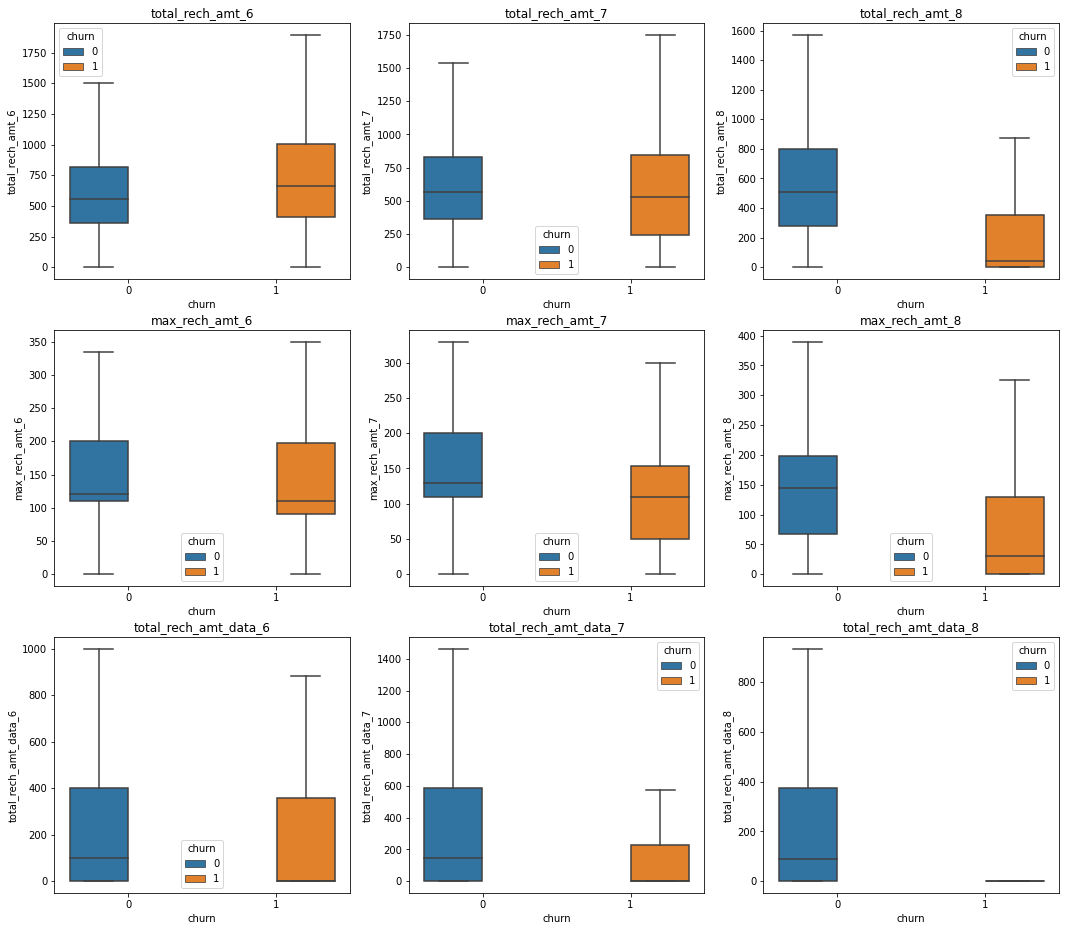

In [28]:
# Plotting recharge amount against churns
plt.figure(figsize=(18, 16))
for i in enumerate(rech_amt_cols):
    ax = plt.subplot(3, 3, i[0]+1)
    ax.title.set_text(i[1])
    sns.boxplot(data=df_hv, y=i[1], x="churn", hue="churn", showfliers=False)

We can see that, in month 6 and 7, the recharge amounts were more or less similar between churners and non-churners. However, in month 8, the recharge amounts by churners fell siginificantly.  

### III.2 Other recharge columns

In [29]:
rech_others = df_hv.columns[df_hv.columns.str.contains('rech_num|max_rech_data',regex=True)]
rech_others

Index(['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8',
       'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8'],
      dtype='object')

In [30]:
# Checking for null values among these columns
df_hv.loc[:,rech_others].isnull().sum()*100/df_hv.shape[0]

total_rech_num_6     0.000000
total_rech_num_7     0.000000
total_rech_num_8     0.000000
max_rech_data_6     44.148528
max_rech_data_7     43.145228
max_rech_data_8     46.825106
dtype: float64

In [31]:
df_hv.loc[:,rech_others].describe()

,total_rech_num_6,total_rech_num_7,total_rech_num_8,max_rech_data_6,max_rech_data_7,max_rech_data_8
count,30001.000000,30001.000000,30001.000000,16756.000000,17057.000000,15953.000000
mean,11.851005,11.718843,9.972868,139.798580,140.431143,136.329217
std,9.429132,9.432418,9.274370,118.851784,120.247247,119.531924
min,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,6.000000,6.000000,4.000000,25.000000,25.000000,25.000000
50%,9.000000,9.000000,8.000000,152.000000,152.000000,152.000000
75%,15.000000,15.000000,13.000000,198.000000,198.000000,198.000000
max,307.000000,138.000000,196.000000,1555.000000,1555.000000,1555.000000


We notice the followings:
* There's no null values in total_rech_num across months.
* There are quite a lot of null values in max_rech_data, where the minimum and maximum are the same across months. Null values could well means no recharges are done in each respective months. We can, therefore, safely impute these nulls by 0

In [32]:
# Imputing null values in max_rech_data_x columns by 0
cols = ['max_rech_data_6','max_rech_data_7','max_rech_data_8']
df_hv[cols] = df_hv[cols].fillna(0)

# Checking null values again
df_hv.loc[:,rech_others].isnull().sum()*100/df_hv.shape[0]

total_rech_num_6    0.0
total_rech_num_7    0.0
total_rech_num_8    0.0
max_rech_data_6     0.0
max_rech_data_7     0.0
max_rech_data_8     0.0
dtype: float64

We can see that null values have been all replaced by 0. Now, let's plot these columns against churn for insights

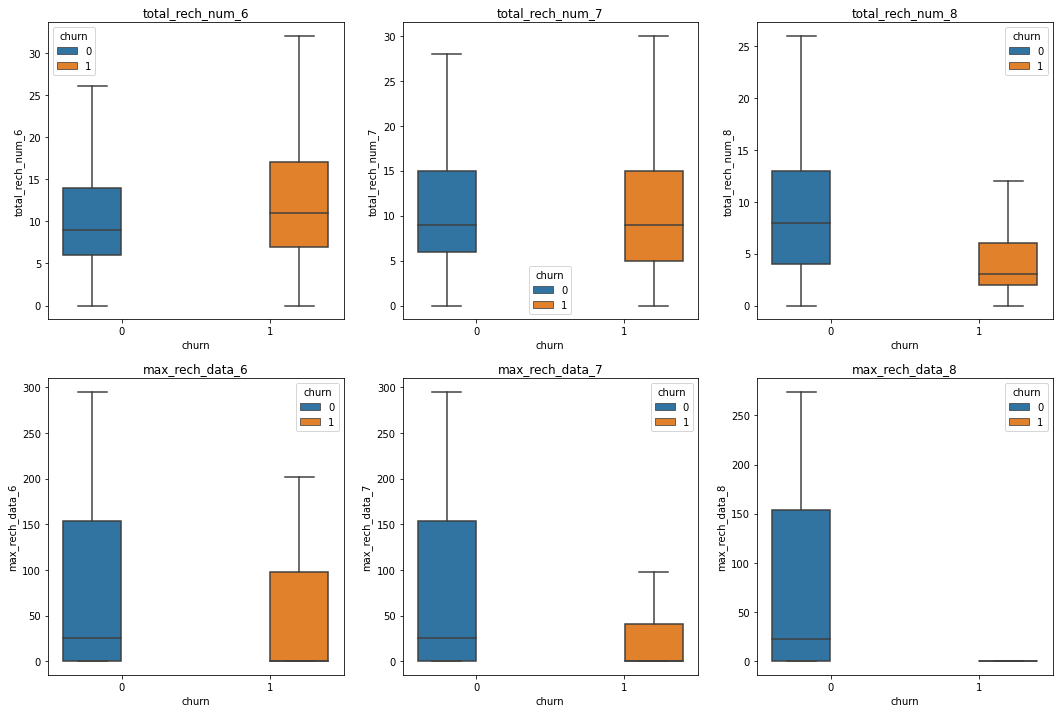

In [33]:
# Plotting recharge amount against churns
plt.figure(figsize=(18, 12))
for i in enumerate(rech_others):
    ax = plt.subplot(2, 3, i[0]+1)
    ax.title.set_text(i[1])
    sns.boxplot(data=df_hv, y=i[1], x="churn", hue="churn", showfliers=False)

We can easily notice similar patterns among other recharge columns with those in recharge amount columns, which showed a significant drop among churners in month 8.

### III.3 2G and 3G usage

In [34]:
# Getting a list of column names for 2G and 3G usage
cols_2g_3g = df_hv.columns[df_hv.columns.str.contains('monthly_2g|monthly_3g',regex=True)]
list(cols_2g_3g)

['monthly_2g_6',
 'monthly_2g_7',
 'monthly_2g_8',
 'monthly_3g_6',
 'monthly_3g_7',
 'monthly_3g_8']

In [35]:
# Checking for null values
df_hv[cols_2g_3g].isnull().sum()*100 / df_hv.shape[0]

monthly_2g_6    0.0
monthly_2g_7    0.0
monthly_2g_8    0.0
monthly_3g_6    0.0
monthly_3g_7    0.0
monthly_3g_8    0.0
dtype: float64

In [36]:
df_hv[cols_2g_3g].describe()

,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8
count,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000
mean,0.174494,0.183261,0.153628,0.217759,0.229026,0.211026
std,0.434953,0.450423,0.406486,0.613199,0.659125,0.617549
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4.000000,5.000000,5.000000,14.000000,16.000000,16.000000


We can see very little usage of 2G and 3G across months 6 - 8 with 0 usage in 25, 50, and 75 quartiles.

### III.4 Minutes of Usage (MOU)

In [37]:
# Getting a list of column names for 2G and 3G usage
cols_mou = df_hv.columns[df_hv.columns.str.contains('mou')]
list(cols_mou)

['onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'spl_og_mou_6',
 'spl_og_mou_7',
 'spl_og_mou_8',
 'total_og_mou_6',
 'total_og_mou_7',
 'total_og_mou_8',
 'loc_ic_t2t_mou_6',
 'loc_ic_t2t_mou_7',
 'loc_ic_t2t_mou_8',
 'loc_ic_t2m_mou_6',
 'loc_i

In [38]:
# Checking for null values among mou columns
df_hv[cols_mou].isnull().sum()*100 / df_hv.shape[0]

onnet_mou_6         1.816606
onnet_mou_7         1.789940
onnet_mou_8         3.913203
offnet_mou_6        1.816606
offnet_mou_7        1.789940
offnet_mou_8        3.913203
roam_ic_mou_6       1.816606
roam_ic_mou_7       1.789940
roam_ic_mou_8       3.913203
roam_og_mou_6       1.816606
roam_og_mou_7       1.789940
roam_og_mou_8       3.913203
loc_og_t2t_mou_6    1.816606
loc_og_t2t_mou_7    1.789940
loc_og_t2t_mou_8    3.913203
loc_og_t2m_mou_6    1.816606
loc_og_t2m_mou_7    1.789940
loc_og_t2m_mou_8    3.913203
loc_og_t2f_mou_6    1.816606
loc_og_t2f_mou_7    1.789940
loc_og_t2f_mou_8    3.913203
loc_og_t2c_mou_6    1.816606
loc_og_t2c_mou_7    1.789940
loc_og_t2c_mou_8    3.913203
loc_og_mou_6        1.816606
loc_og_mou_7        1.789940
loc_og_mou_8        3.913203
std_og_t2t_mou_6    1.816606
std_og_t2t_mou_7    1.789940
std_og_t2t_mou_8    3.913203
std_og_t2m_mou_6    1.816606
std_og_t2m_mou_7    1.789940
std_og_t2m_mou_8    3.913203
std_og_t2f_mou_6    1.816606
std_og_t2f_mou

The maximum percentage of null values is 3.91% which is not much. Null values may imply no usage at all, and therefore can be replaced with 0.

In [39]:
df_hv[cols_mou] = df_hv[cols_mou].fillna(0)

Let's have a closer look at columns for outgoing calls (those which incur charges) for a particular month, month 6 for example.

#### III.4.1 Checking out-going MOU

In [40]:
cols_og_6 = df_hv.columns[df_hv.columns.str.contains('.*_og_.*mou_6',regex=True)]
df[cols_og_6].describe()

,roam_og_mou_6,loc_og_t2t_mou_6,loc_og_t2m_mou_6,loc_og_t2f_mou_6,loc_og_t2c_mou_6,loc_og_mou_6,std_og_t2t_mou_6,std_og_t2m_mou_6,std_og_t2f_mou_6,std_og_mou_6,isd_og_mou_6,spl_og_mou_6,total_og_mou_6
count,96062.000000,96062.000000,96062.000000,96062.000000,96062.000000,96062.000000,96062.000000,96062.000000,96062.000000,96062.000000,96062.000000,96062.000000,99999.000000
mean,13.911337,47.100763,93.342088,3.751013,1.123056,144.201175,79.829870,87.299624,1.129011,168.261218,0.798277,3.916811,305.133424
std,71.443196,150.856393,162.780544,14.230438,5.448946,251.751489,252.476533,255.617850,7.984970,389.948499,25.765248,14.936449,463.419481
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.660000,9.880000,0.000000,0.000000,17.110000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,44.740000
50%,0.000000,11.910000,41.030000,0.000000,0.000000,65.110000,0.000000,3.950000,0.000000,11.640000,0.000000,0.000000,145.140000
75%,0.000000,40.960000,110.390000,2.080000,0.000000,168.270000,30.807500,53.290000,0.000000,144.837500,0.000000,2.430000,372.860000
max,3775.110000,6431.330000,4729.740000,1466.030000,342.860000,10643.380000,7366.580000,8314.760000,628.560000,8432.990000,5900.660000,1023.210000,10674.030000


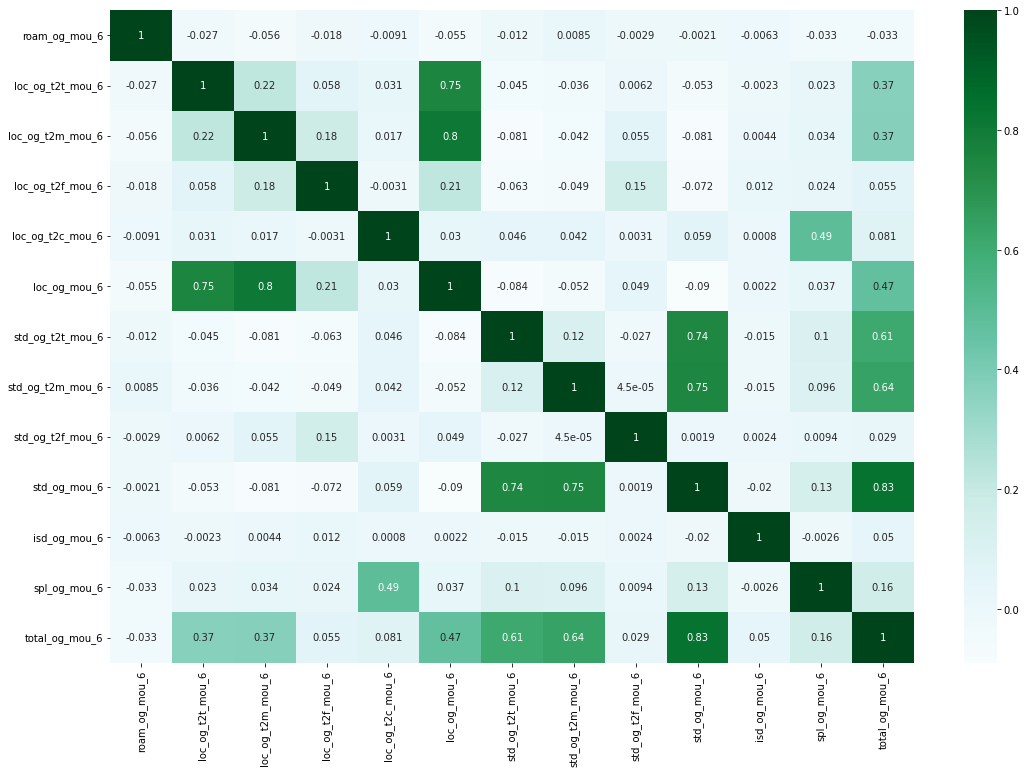

In [41]:
# Plotting a correllation heatmap for these columns
plt.figure(figsize=(18,12))
sns.heatmap(df_hv[cols_og_6].corr(),cmap="BuGn",annot=True)
plt.show()

We can notice that some columns have rather high correllation with their sub-columns:
* total_og_mou_6 v.s std_og_mou_6 (0.83) 
* std_og_mou_6 v.s std_og_t2t_mou_6 and std_og_t2m_mou_6,
* loc_og_mou_6 v.s loc_og_t2t_mou_6 and loc_og_t2m_mou_6

We can drop these columns for other months as well.

In [42]:
cols_og_total = df_hv.columns[df_hv.columns.str.contains('total_og_mou|std_og_mou|loc_og_mou',regex=True)]
df_hv.drop(cols_og_total,axis=1,inplace=True)

In [43]:
cols_og_6 = list(set(cols_og_6) - set(cols_og_total))

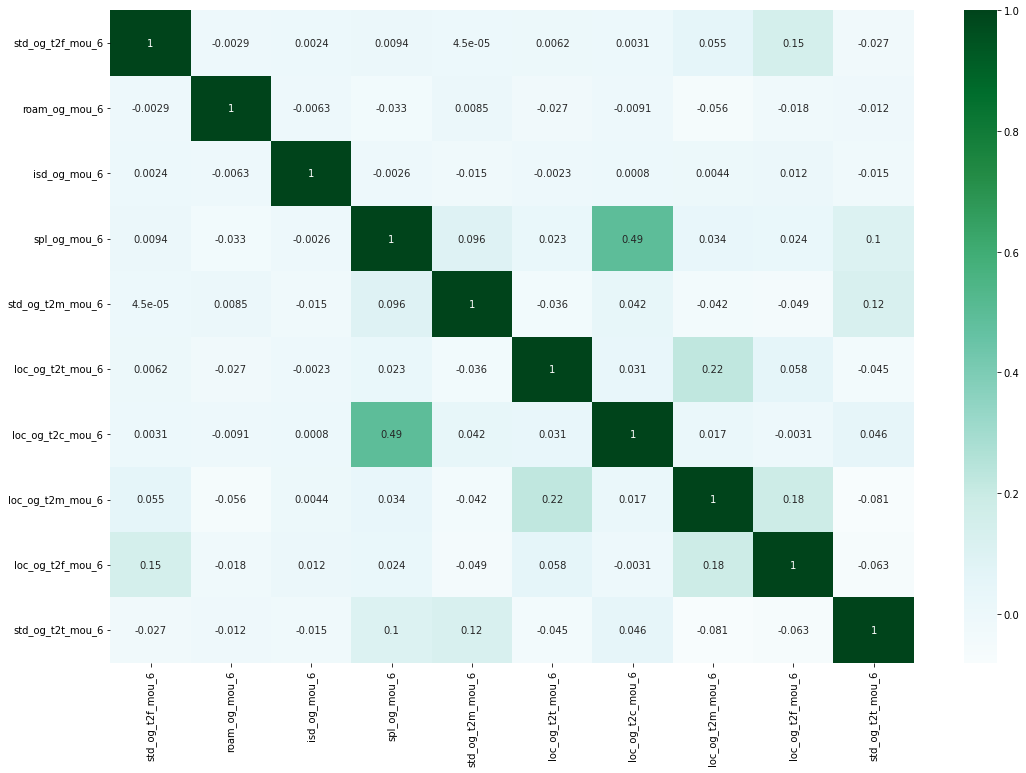

In [44]:
# Let's plot the heatmap again
plt.figure(figsize=(18,12))
sns.heatmap(df_hv[cols_og_6].corr(),cmap="BuGn",annot=True)
plt.show()

We can see that there's no columns having high correllation anymore.

#### III.4.2 Checking incoming MOU

In [45]:
cols_ic_6 = df_hv.columns[df_hv.columns.str.contains('.*_ic_.*mou_6',regex=True)]
df[cols_ic_6].describe()

,roam_ic_mou_6,loc_ic_t2t_mou_6,loc_ic_t2m_mou_6,loc_ic_t2f_mou_6,loc_ic_mou_6,std_ic_t2t_mou_6,std_ic_t2m_mou_6,std_ic_t2f_mou_6,std_ic_mou_6,total_ic_mou_6,spl_ic_mou_6,isd_ic_mou_6
count,96062.000000,96062.000000,96062.000000,96062.000000,96062.000000,96062.000000,96062.000000,96062.000000,96062.000000,99999.000000,96062.000000,96062.000000
mean,9.950013,47.922365,107.475650,12.084305,167.491059,9.575993,20.722240,2.156397,32.457179,200.130037,0.061557,7.460608
std,72.825411,140.258485,171.713903,40.140895,254.124029,54.330607,80.793414,16.495594,106.283386,291.651671,0.160920,59.722948
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.990000,17.290000,0.000000,30.390000,0.000000,0.000000,0.000000,0.000000,38.530000,0.000000,0.000000
50%,0.000000,15.690000,56.490000,0.880000,92.160000,0.000000,2.030000,0.000000,5.890000,114.740000,0.000000,0.000000
75%,0.000000,46.840000,132.387500,8.140000,208.075000,4.060000,15.030000,0.000000,26.930000,251.670000,0.000000,0.000000
max,13724.380000,6626.930000,4693.860000,1872.340000,7454.630000,5459.560000,5647.160000,1351.110000,5712.110000,7716.140000,19.760000,6789.410000


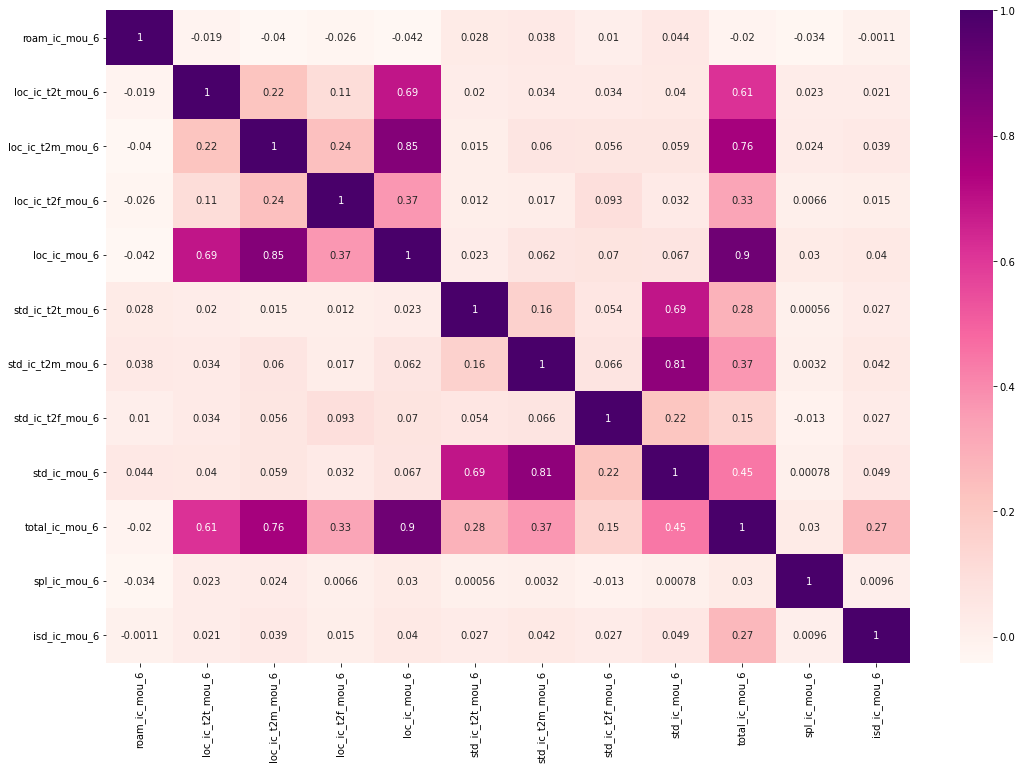

In [46]:
# Plotting a correllation heatmap for these columns
plt.figure(figsize=(18,12))
sns.heatmap(df_hv[cols_ic_6].corr(),cmap='RdPu',annot=True)
plt.show()

In [47]:
# Dropping highly corelated attributes
cols_ic_total = df_hv.columns[df_hv.columns.str.contains('total_ic_mou|std_ic_mou|loc_ic_mou',regex=True)]
df_hv.drop(cols_ic_total,axis=1,inplace=True)

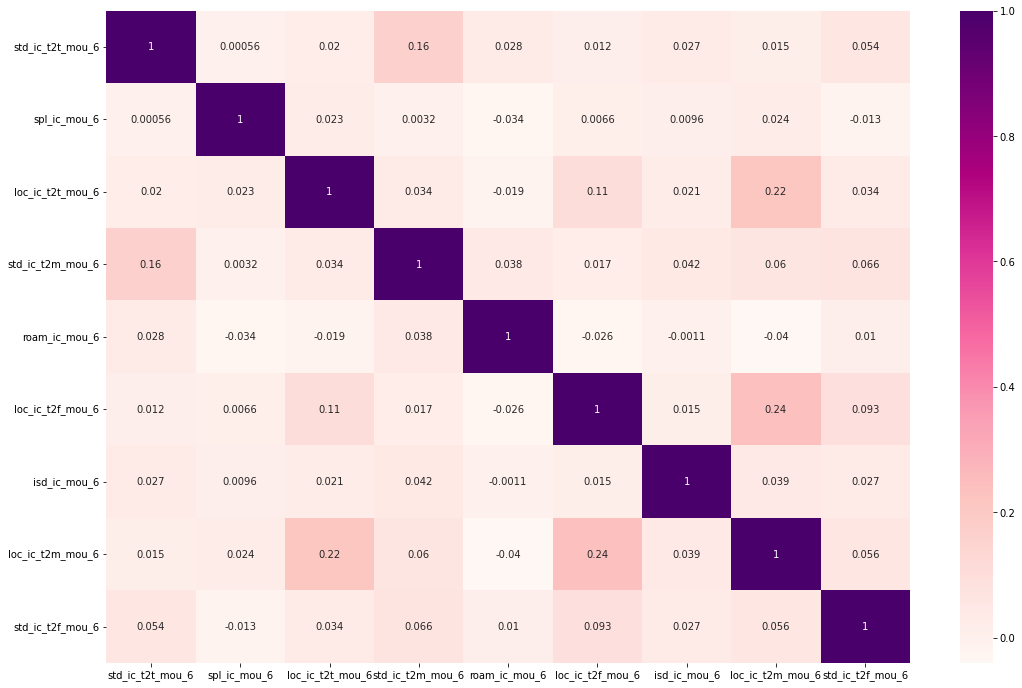

In [48]:
cols_ic_6 = list(set(cols_ic_6) - set(cols_ic_total))
plt.figure(figsize=(18,12))
sns.heatmap(df_hv[cols_ic_6].corr(),cmap='RdPu',annot=True)
plt.show()

### III.5 Checking tenure - Age on Network (aon)

In [49]:
aon_data = df_hv.copy()
aon_data['tenure'] = aon_data['aon']/30 # converting aon in days to months

<AxesSubplot:>

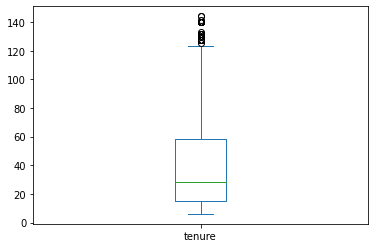

In [50]:
aon_data['tenure'].plot.box()

In [51]:
aon_range = [0, 6, 12, 24, 60, 61]
aon_label = [ '0-6 Months', '6-12 Months', '12-24 Months', '24-60 Months', '60 Months or more']
aon_data['aon_range'] = pd.cut(aon_data['tenure'], aon_range, labels=aon_label)
aon_data['aon_range'].head()

0     24-60 Months
7     24-60 Months
8      6-12 Months
21    12-24 Months
23    12-24 Months
Name: aon_range, dtype: category
Categories (5, object): ['0-6 Months' < '6-12 Months' < '12-24 Months' < '24-60 Months' < '60 Months or more']

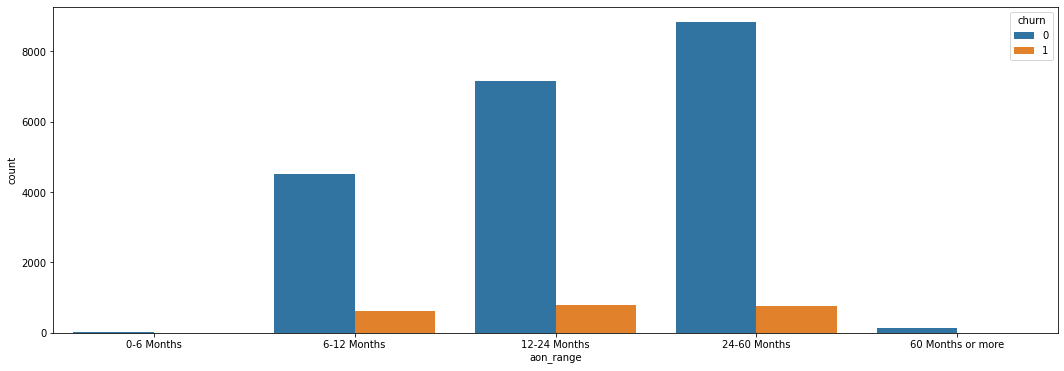

In [52]:
plt.figure(figsize=(18,6))
sns.countplot(x = 'aon_range', hue = 'churn', data = aon_data)
plt.show()

We can see from the chart that users aged 60 months or more are less likely to churn.

### III.6 Checking Average Revenue Per User (ARPU)

In [121]:
cols_arpu = df_hv.columns[df_hv.columns.str.contains('arpu',regex=True)]
df_hv[cols_arpu].describe()

,arpu_6,arpu_7,arpu_8
count,30001.000000,30001.000000,30001.000000
mean,558.490824,560.782203,508.597957
std,460.640461,479.776947,501.961981
min,-2258.709000,-2014.045000,-945.808000
25%,309.865000,309.826000,231.473000
50%,481.694000,480.943000,427.585000
75%,699.943000,698.315000,661.491000
max,27731.088000,35145.834000,33543.624000


In [123]:
df_hv[cols_arpu].isnull().sum()*100 / nrows

arpu_6    0.0
arpu_7    0.0
arpu_8    0.0
dtype: float64

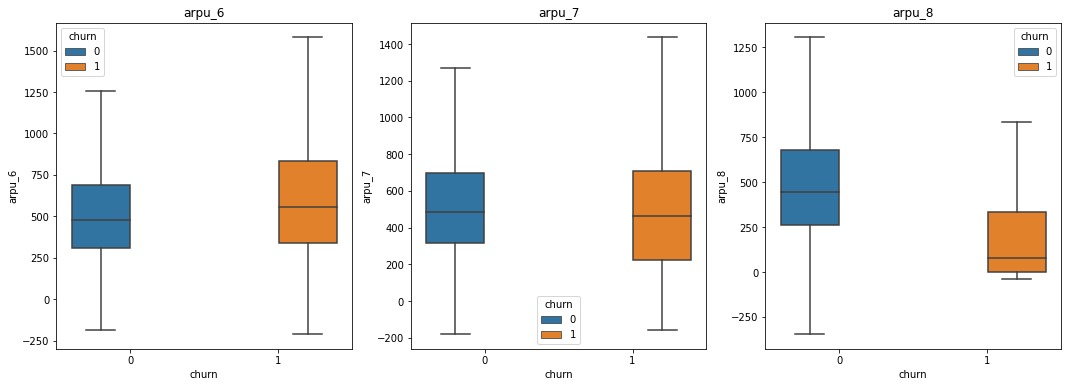

In [122]:
# Plotting arpu against churns
plt.figure(figsize=(18, 6))
for i in enumerate(cols_arpu):
    ax = plt.subplot(1, 3, i[0]+1)
    ax.title.set_text(i[1])
    sns.boxplot(data=df_hv, y=i[1], x="churn", hue="churn", showfliers=False)

ARPU for churners fell abruptly in month 8.

### III.7 Checking null values in remaining columns

In [53]:
# Drop Columns with >= 30% of missing values
null_pct = df_hv.isnull().sum() * 100 / df_hv.shape[0]
null_pct

arpu_6                       0.000000
arpu_7                       0.000000
arpu_8                       0.000000
onnet_mou_6                  0.000000
onnet_mou_7                  0.000000
onnet_mou_8                  0.000000
offnet_mou_6                 0.000000
offnet_mou_7                 0.000000
offnet_mou_8                 0.000000
roam_ic_mou_6                0.000000
roam_ic_mou_7                0.000000
roam_ic_mou_8                0.000000
roam_og_mou_6                0.000000
roam_og_mou_7                0.000000
roam_og_mou_8                0.000000
loc_og_t2t_mou_6             0.000000
loc_og_t2t_mou_7             0.000000
loc_og_t2t_mou_8             0.000000
loc_og_t2m_mou_6             0.000000
loc_og_t2m_mou_7             0.000000
loc_og_t2m_mou_8             0.000000
loc_og_t2f_mou_6             0.000000
loc_og_t2f_mou_7             0.000000
loc_og_t2f_mou_8             0.000000
loc_og_t2c_mou_6             0.000000
loc_og_t2c_mou_7             0.000000
loc_og_t2c_m

In [54]:
# Getting a list columns with over 30% null values
null_pct_gte30 = []
for col in list(null_pct.keys()):
    if null_pct[col] >= 30:
        null_pct_gte30.append(col)
null_pct_gte30

['date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8',
 'count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'count_rech_3g_6',
 'count_rech_3g_7',
 'count_rech_3g_8',
 'arpu_3g_6',
 'arpu_3g_7',
 'arpu_3g_8',
 'arpu_2g_6',
 'arpu_2g_7',
 'arpu_2g_8',
 'night_pck_user_6',
 'night_pck_user_7',
 'night_pck_user_8',
 'fb_user_6',
 'fb_user_7',
 'fb_user_8']

In [55]:
# Dropping columns with null value percentage equals or larger than 30%
df_hv.drop(null_pct_gte30, axis=1, inplace=True)
df_hv.shape

(30001, 118)

In [56]:
# Handling remaining columns with null values
null_pct = df_hv.isnull().sum() * 100 / df_hv.shape[0]
null_pct.loc[lambda x: x > 0.0]

og_others_6            1.816606
og_others_7            1.789940
og_others_8            3.913203
ic_others_6            1.816606
ic_others_7            1.789940
ic_others_8            3.913203
date_of_last_rech_6    0.243325
date_of_last_rech_7    0.326656
date_of_last_rech_8    1.943269
dtype: float64

In [57]:
# We can impute null values in these columns by 0
null_cols = list(null_pct.loc[lambda x: x > 0.0].keys())
for col in null_cols:
    null_index = df_hv[col].isnull().index
    df_hv.loc[null_index, col] = 0

### III.8 Combining month 6 and month 7 columns into average columns

As data for the good phase are consider together, we can combine data in month 6 and month 7 into new columns containing the average values of each month repsective column.

In [58]:
df_final = df_hv.copy()
df_final.drop(['good_phase_av_rev'], axis=1, inplace=True)

In [59]:
# Filtering out month 6 and month 7 columns, and remove the month number
cols = df_final.filter(regex='_6|_7').columns.str[:-2]
cols

Index(['arpu', 'arpu', 'onnet_mou', 'onnet_mou', 'offnet_mou', 'offnet_mou',
       'roam_ic_mou', 'roam_ic_mou', 'roam_og_mou', 'roam_og_mou',
       'loc_og_t2t_mou', 'loc_og_t2t_mou', 'loc_og_t2m_mou', 'loc_og_t2m_mou',
       'loc_og_t2f_mou', 'loc_og_t2f_mou', 'loc_og_t2c_mou', 'loc_og_t2c_mou',
       'std_og_t2t_mou', 'std_og_t2t_mou', 'std_og_t2m_mou', 'std_og_t2m_mou',
       'std_og_t2f_mou', 'std_og_t2f_mou', 'isd_og_mou', 'isd_og_mou',
       'spl_og_mou', 'spl_og_mou', 'og_others', 'og_others', 'loc_ic_t2t_mou',
       'loc_ic_t2t_mou', 'loc_ic_t2m_mou', 'loc_ic_t2m_mou', 'loc_ic_t2f_mou',
       'loc_ic_t2f_mou', 'std_ic_t2t_mou', 'std_ic_t2t_mou', 'std_ic_t2m_mou',
       'std_ic_t2m_mou', 'std_ic_t2f_mou', 'std_ic_t2f_mou', 'spl_ic_mou',
       'spl_ic_mou', 'isd_ic_mou', 'isd_ic_mou', 'ic_others', 'ic_others',
       'total_rech_num', 'total_rech_num', 'total_rech_amt', 'total_rech_amt',
       'max_rech_amt', 'max_rech_amt', 'date_of_last_rech',
       'date_of_last_r

In [60]:
# Generate the new columns containing average value of each month respective column
for k, v in enumerate(cols.unique()):
    avg_col_name = v + "_av67"
    col_6 = v+"_6"
    col_7 = v+"_7"
    df_final[avg_col_name] = (df_final[col_6]  + df_final[col_7])/ 2

In [61]:
# After that, we drop month 6 and month 7 columns, as they already have their representation in the 
# average columns we created in the previous step
cols_to_drop = df_final.filter(regex='_6|_7')
df_final.drop(cols_to_drop, axis=1, inplace=True)
df_final.shape

(30001, 80)

In [62]:
df_final.head()

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,date_of_last_rech_8,last_day_rch_amt_8,max_rech_data_8,vol_2g_mb_8,vol_3g_mb_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_rech_amt_data_8,churn,arpu_av67,onnet_mou_av67,offnet_mou_av67,roam_ic_mou_av67,roam_og_mou_av67,loc_og_t2t_mou_av67,loc_og_t2m_mou_av67,loc_og_t2f_mou_av67,loc_og_t2c_mou_av67,std_og_t2t_mou_av67,std_og_t2m_mou_av67,std_og_t2f_mou_av67,isd_og_mou_av67,spl_og_mou_av67,og_others_av67,loc_ic_t2t_mou_av67,loc_ic_t2m_mou_av67,loc_ic_t2f_mou_av67,std_ic_t2t_mou_av67,std_ic_t2m_mou_av67,std_ic_t2f_mou_av67,spl_ic_mou_av67,isd_ic_mou_av67,ic_others_av67,total_rech_num_av67,total_rech_amt_av67,max_rech_amt_av67,date_of_last_rech_av67,last_day_rch_amt_av67,max_rech_data_av67,vol_2g_mb_av67,vol_3g_mb_av67,monthly_2g_av67,sachet_2g_av67,monthly_3g_av67,sachet_3g_av67,total_rech_amt_data_av67
0,213.803,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.16,4.13,1.15,0.00,0.00,0.00,0.0,0.00,0.0,2,252,252,0,252,252.0,5.75,109.61,0,0,1,0,968,30.40,0.00,101.20,3.58,252.0,1,206.1005,0.00,0.000,0.00,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.00,0.000,0.00,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,3.5,307.0,252.0,0.0,252.0,252.0,15.725,117.165,0.0,0.0,1.0,0.0,252.0
7,3171.480,52.29,325.91,31.64,38.06,40.28,162.28,53.23,0.00,12.01,49.14,16.68,10.01,6.50,0.0,27.31,121.19,39.53,30.39,141.33,22.21,0.0,31.59,0.0,7,3638,1580,0,779,0.0,0.00,0.00,0,0,0,0,802,57.74,19.38,18.74,0.00,0.0,1,1209.5150,56.26,510.295,24.86,18.165,41.385,378.005,58.635,0.0,13.795,40.825,13.37,0.090,2.25,0.0,45.200,219.525,126.810,24.360,109.215,43.215,0.105,8.295,0.0,5.0,1185.0,1185.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0
8,137.362,35.08,136.48,0.00,0.00,12.49,50.54,0.00,7.15,22.58,75.69,0.00,0.00,10.23,0.0,0.31,15.48,0.00,0.10,0.65,0.00,0.0,0.00,0.0,14,120,30,0,10,23.0,0.03,11.94,0,3,0,0,315,21.03,910.65,122.16,0.00,207.0,0,435.4720,382.36,87.645,0.00,0.000,257.360,75.770,0.000,0.0,124.995,11.865,0.00,0.000,0.00,0.0,16.840,35.780,0.000,0.290,13.255,0.000,0.000,0.000,0.0,20.0,519.0,122.0,0.0,25.0,77.0,178.000,375.475,0.5,0.5,0.0,0.0,177.0
21,637.760,85.14,983.39,0.00,0.00,23.34,104.81,1.58,0.00,61.79,876.99,0.00,0.00,0.00,0.0,19.54,129.16,10.39,0.18,101.74,0.00,0.0,0.00,0.0,27,718,50,0,50,0.0,0.00,0.00,0,0,0,0,720,0.00,0.00,0.00,0.00,0.0,0,556.1030,117.26,827.305,0.00,0.000,5.320,89.870,0.375,0.0,111.935,737.050,0.00,0.000,0.00,0.0,6.335,96.430,3.725,10.020,52.960,0.000,0.000,0.000,0.0,24.0,640.0,50.0,0.0,25.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0
23,366.966,33.58,205.89,0.00,0.00,33.58,148.56,0.00,17.71,0.00,39.61,0.00,0.00,17.71,0.0,76.64,146.84,0.71,13.38,43.91,0.00,0.0,3.74,0.0,4,439,179,0,0,179.0,0.01,1009.92,0,0,1,1,604,40.45,51.86,0.00,0.00,540.0,0,134.1235,49.81,87.385,0.00,0.000,49.810,82.975,0.000,0.0,0.000,4.355,0.00,0.005,0.05,0.0,40.875,104.635,0.000,0.255,8.660,0.000,0.000,14.115,0.0,4.0,227.0,89.5,0.0,89.5,89.5,0.240,299.545,0.0,0.0,1.0,0.0,356.0


## IV. Model building

### IV.1 Splitting into train, test data sets

In [63]:
from sklearn.model_selection import train_test_split

# Putting feature variable to X
X = df_final.drop(['churn'], axis=1)

# Putting response variable to y
y = df_final['churn']

y.head()


0     1
7     1
8     0
21    0
23    0
Name: churn, dtype: int64

In [64]:
# Scaling data using Standard Scaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_cols = X.columns 
X_scaled = scaler.fit_transform(X) # in numpy ndarray format
X_scaled = pd.DataFrame(X_scaled, columns=X_cols) # converting back to dataframe for easy processing

In [65]:
# Splitting data into X_train, X_test, y_train, and y_test (70% train, and 30% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size = 0.7, test_size = 0.3, random_state=50)

### IV.2 Feature reduction and selections using PCA

In [66]:
from sklearn.decomposition import PCA, IncrementalPCA

In [67]:
pca = PCA(random_state=20)

In [68]:
pca.fit(X_train)

PCA(random_state=20)

In [69]:
pca.components_

array([[ 2.15121762e-01,  1.29506548e-02,  8.52775118e-02, ...,
         2.21769208e-01,  2.09449850e-02,  9.91427876e-02],
       [ 2.04292340e-01,  2.02763940e-01,  2.45826523e-01, ...,
        -1.29859947e-01, -7.90894309e-02, -1.57280270e-01],
       [ 1.09355259e-01,  1.44176226e-01,  4.40956081e-02, ...,
         7.16537305e-02,  2.01213571e-01,  2.62497742e-01],
       ...,
       [-0.00000000e+00,  5.39932682e-16,  9.62776123e-16, ...,
        -2.77555756e-17, -8.32667268e-17,  1.38777878e-17],
       [-0.00000000e+00, -4.82469967e-17, -7.58333857e-17, ...,
        -2.60208521e-18, -1.38777878e-17, -3.46944695e-17],
       [-0.00000000e+00,  7.50094431e-15,  7.86114397e-16, ...,
        -5.55111512e-17, -5.55111512e-17, -0.00000000e+00]])

In [70]:
pca.explained_variance_ratio_

array([9.70436846e-02, 9.25369161e-02, 6.11571383e-02, 4.78666303e-02,
       4.29905420e-02, 3.65011388e-02, 3.44261944e-02, 3.34137390e-02,
       3.13213607e-02, 2.93590329e-02, 2.75078579e-02, 2.60498792e-02,
       2.37491292e-02, 2.28119448e-02, 2.16239931e-02, 1.97869675e-02,
       1.86989539e-02, 1.73926687e-02, 1.65443753e-02, 1.63614469e-02,
       1.53649518e-02, 1.47600302e-02, 1.46084427e-02, 1.29524811e-02,
       1.18830948e-02, 1.13186234e-02, 1.09255363e-02, 1.06425231e-02,
       1.04107201e-02, 1.00308319e-02, 9.87432874e-03, 9.38935164e-03,
       8.81973244e-03, 8.65304754e-03, 8.45481814e-03, 7.20820083e-03,
       6.71289658e-03, 6.59804683e-03, 6.00436320e-03, 5.50071877e-03,
       5.19875039e-03, 4.96885480e-03, 4.63916004e-03, 4.59995183e-03,
       4.43126621e-03, 4.18669157e-03, 4.14767504e-03, 3.84727675e-03,
       3.70679128e-03, 3.54495014e-03, 3.46591617e-03, 3.31079657e-03,
       3.23281764e-03, 3.08553833e-03, 3.01866502e-03, 2.83040886e-03,
      

In [71]:
cumulative_var = np.cumsum(pca.explained_variance_ratio_)

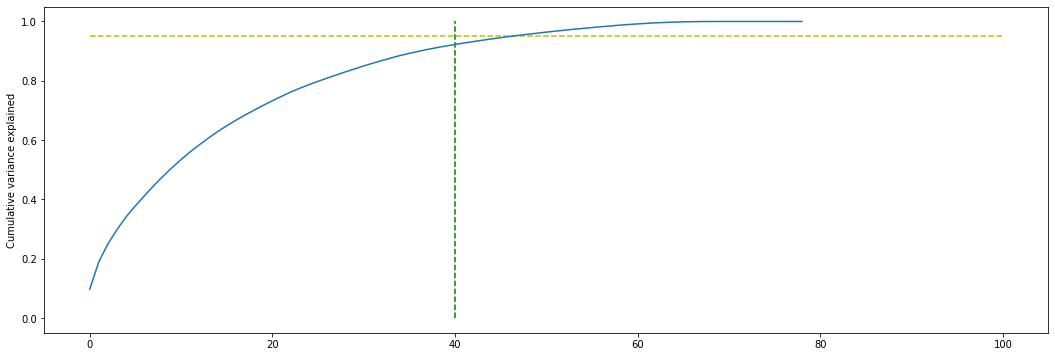

In [72]:
# Plotting cumulative_var to aid in selecting the right number of components

fig = plt.figure(figsize=[18,6])
plt.vlines(x=40, ymax=1, ymin=0, colors="g", linestyles="--")
plt.hlines(y=0.95, xmax=100, xmin=0, colors="y", linestyles="--")
plt.plot(cumulative_var)
plt.ylabel("Cumulative variance explained")
plt.show()

The scree chart suggests that 45 components would be able to explain 95% of the variance. We, therefore, can use 45 for our modeling.

In [73]:
pca_final = IncrementalPCA(n_components=45)

In [74]:
df_train_pca = pca_final.fit_transform(X_train)

In [75]:
df_train_pca.shape

(21000, 45)

In [76]:
# Transforming test set using pca of the train set
df_test_pca = pca_final.transform(X_test)
df_test_pca.shape

(9001, 45)

### V.3 Modeling

#### V.3.1 Logistic Regression Modeling

Let's start our modeling with a Logistic Regression model

In [77]:
from sklearn.linear_model import LogisticRegression

In [78]:
lg_model = LogisticRegression(random_state = 35)

In [79]:
# Fitting the model using df_train_pca
lg_model_fit = lg_model.fit(df_train_pca, y_train)

In [80]:
train_pred_prob = lg_model_fit.predict_proba(df_train_pca)
train_pred_prob = [prob[1] for prob in train_pred_prob]

In [81]:
# Let build the predictions into a dataframe for easy evaluation
train_pred_final = pd.DataFrame({'Churned': y_train.values, 'Churn_Prob': train_pred_prob})
train_pred_final.head()

,Churned,Churn_Prob
0,0,0.020047
1,0,0.035202
2,0,0.076812
3,0,0.001508
4,0,0.149600


In [82]:
cut_off = 0.3
train_pred_final['Predicted'] = train_pred_final.Churn_Prob.map(lambda x: 1 if x > cut_off else 0)
# Let's see the head
train_pred_final.head()

,Churned,Churn_Prob,Predicted
0,0,0.020047,0
1,0,0.035202,0
2,0,0.076812,0
3,0,0.001508,0
4,0,0.149600,0


In [83]:
# Import metrics from sklearn for evaluation
from sklearn import metrics

In [84]:
# Create confusion matrix 
confusion = metrics.confusion_matrix(train_pred_final.Churned, train_pred_final.Predicted )
print(confusion)

[[18420   833]
 [  735  1012]]


In [85]:
# Let's evaluate the other metrics as well
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [86]:
sensitivity = TP/(TP+FN)
sensitivity

0.5792787635947338

In [87]:
# define a function to plot ROC curve
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve(actual, probs, drop_intermediate = False )
    auc_score = metrics.roc_auc_score(actual, probs)
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    return None

In [88]:
fpr, tpr, thresholds = metrics.roc_curve(train_pred_final.Churned, train_pred_final.Churn_Prob, drop_intermediate = False)

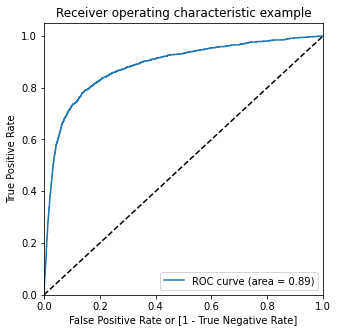

In [89]:
# Call the ROC function
draw_roc(train_pred_final.Churned, train_pred_final.Churn_Prob)

In [90]:
numbers = [float(x)/10 for x in np.arange(0, 10, 0.5)]

In [91]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in np.arange(0, 10, 0.5)]
for i in numbers:
    train_pred_final[i] = train_pred_final.Churn_Prob.map(lambda x: 1 if x > i else 0)
train_pred_final.head()

,Churned,Churn_Prob,Predicted,0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95
0,0,0.020047,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0.035202,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0.076812,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0.001508,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0.149600,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [92]:
# Now, let's create a dataframe to see the performance metrics at different values of probabiity cutoffs

cutoff_df = pd.DataFrame(columns = ['Prob','Accuracy','Sensitivity','Specificity'])
from sklearn.metrics import confusion_matrix

for i in numbers:
    cm1 = metrics.confusion_matrix(train_pred_final.Churned, train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1    
    specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensitivity,specificity]
print(cutoff_df)

      Prob  Accuracy  Sensitivity  Specificity
0.00  0.00  0.083190     1.000000     0.000000
0.05  0.05  0.704810     0.883228     0.688620
0.10  0.10  0.826000     0.807098     0.827715
0.15  0.15  0.877095     0.739554     0.889576
0.20  0.20  0.902810     0.690326     0.922090
0.25  0.25  0.916429     0.634803     0.941983
0.30  0.30  0.925333     0.579279     0.956734
0.35  0.35  0.928667     0.492272     0.968265
0.40  0.40  0.928381     0.395535     0.976731
0.45  0.45  0.927333     0.297081     0.984522
0.50  0.50  0.925238     0.214654     0.989716
0.55  0.55  0.922571     0.152261     0.992469
0.60  0.60  0.921286     0.108185     0.995066
0.65  0.65  0.920429     0.077275     0.996936
0.70  0.70  0.920000     0.062393     0.997819
0.75  0.75  0.919190     0.046938     0.998338
0.80  0.80  0.918524     0.030338     0.999117
0.85  0.85  0.917667     0.018317     0.999273
0.90  0.90  0.917619     0.013738     0.999636
0.95  0.95  0.917286     0.005724     1.000000


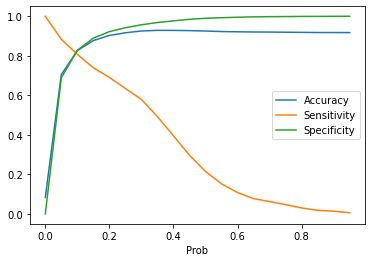

In [93]:
# And now let's plot these lines
cutoff_df.plot.line(x='Prob', y=['Accuracy','Sensitivity','Specificity'])
plt.show()

We can see that the model produced the best result at a cut-off rate of around 10%. Let's make predictions on the test set

In [94]:
test_pred_prob = lg_model_fit.predict_proba(df_test_pca)
test_pred_prob = [prob[1] for prob in test_pred_prob]

In [95]:
# Let build the predictions into a dataframe for easy evaluation
test_pred_final = pd.DataFrame({'Churned': y_test.values, 'Churn_Prob': test_pred_prob})
test_pred_final.head()

,Churned,Churn_Prob
0,0,0.008397
1,0,0.010050
2,0,0.162845
3,0,0.019229
4,0,0.167379


In [96]:
cut_off = 0.10
test_pred_final['Predicted'] = test_pred_final.Churn_Prob.map(lambda x: 1 if x > cut_off else 0)
# Let's see the head
test_pred_final.head()

,Churned,Churn_Prob,Predicted
0,0,0.008397,0
1,0,0.010050,0
2,0,0.162845,1
3,0,0.019229,0
4,0,0.167379,1


In [97]:
# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

confusion = confusion_matrix(y_test, test_pred_final.Predicted)
print("Confusion Matrix:", "\n")
print(confusion)
print("Classification Report:", "\n")
print(classification_report(y_test, test_pred_final.Predicted))
print("Accuracy Score:", "\n")
print(accuracy_score(y_test, test_pred_final.Predicted))

Confusion Matrix: 

[[6934 1373]
 [ 129  565]]
Classification Report: 

              precision    recall  f1-score   support

           0       0.98      0.83      0.90      8307
           1       0.29      0.81      0.43       694

    accuracy                           0.83      9001
   macro avg       0.64      0.82      0.67      9001
weighted avg       0.93      0.83      0.87      9001

Accuracy Score: 

0.8331296522608599


We can see that the model can correctly identify churners by 81%, while it can predict non-churners by 83%. 

In [113]:
print("Important features by Logistic Regression are:")
# plt.figure(figsize=(6,4))
# sns.countplot(x = 'tenure_range', hue = 'churn',data = tenure_data,palette=("plasma"))
# plt.show()

cols = list(X_scaled.columns)
df_pca = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'PC3':pca.components_[2],'Feature':cols})
df_pca.head(15)

Important features by Logistic Regression are:


,PC1,PC2,PC3,Feature
0,2.151218e-01,0.204292,1.093553e-01,arpu_8
1,1.295065e-02,0.202764,1.441762e-01,onnet_mou_8
2,8.527751e-02,0.245827,4.409561e-02,offnet_mou_8
3,3.722328e-02,0.038220,1.176069e-02,roam_ic_mou_8
4,3.769277e-02,0.064262,3.538293e-02,roam_og_mou_8
5,6.348333e-02,0.106469,-1.257919e-02,loc_og_t2t_mou_8
6,1.287837e-01,0.145438,-1.173387e-01,loc_og_t2m_mou_8
7,1.017823e-01,0.049686,-1.443659e-01,loc_og_t2f_mou_8
8,-1.301053e-03,0.042760,8.850523e-02,loc_og_t2c_mou_8
9,-2.421383e-02,0.166719,1.691332e-01,std_og_t2t_mou_8


#### V.3.2 Random Forest

Now, let's try with another model - a Random Forest Model

In [98]:
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier

# Running the random forest with default parameters.
rfc_model = RandomForestClassifier()

In [100]:
rfc_model_fit = rfc_model.fit(X_train, y_train)

In [101]:
# Making predictions on the test set
rfc_pred = rfc_model_fit.predict(X_test)

In [103]:
rfc_confusion = confusion_matrix(y_test, rfc_pred)
print("Confusion Matrix:", "\n")
print(rfc_confusion)
print("Classification Report:", "\n")
print(classification_report(y_test, rfc_pred))
print("Accuracy Score:", "\n")
print(accuracy_score(y_test, rfc_pred))

Confusion Matrix: 

[[8180  127]
 [ 371  323]]
Classification Report: 

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      8307
           1       0.72      0.47      0.56       694

    accuracy                           0.94      9001
   macro avg       0.84      0.73      0.77      9001
weighted avg       0.94      0.94      0.94      9001

Accuracy Score: 

0.9446728141317632


We can see that, the model with default parameters can only predict churners correctly by 47%. Next, let's tune the parameters to improve the model performance

In [104]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# Folds for k-fold CV
n_folds = 5

## Lets define a generic method to tune different parameters.
def model_finetune(param) :
    rf = RandomForestClassifier()
    
    rf = GridSearchCV(rf, param, 
                    cv=n_folds, 
                   scoring="recall",
                  return_train_score=True)
    rf.fit(X_train, y_train)
    return rf

## We will also define a method to plot the graph of model after tuning
def plot_the_model_performance(modelParam, model, results):
    # plotting accuracies with given param
    plt.figure()
    plt.plot(results[modelParam], 
             results["mean_train_score"], 
             label="training recall")
    plt.plot(results[modelParam], 
             results["mean_test_score"], 
             label="test recall")
    plt.xlabel(modelParam)
    plt.ylabel("Recall")
    plt.legend()
    plt.show()

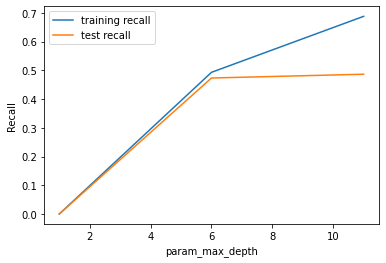

In [105]:
# Let's try to fine tune max_depth first.
params = {'max_depth': range(1, 15, 5)}
rf = model_finetune(params)
results = rf.cv_results_
plot_the_model_performance("param_max_depth", rf, results)

We can see that as we increase max depth, both train and test score increase. However, up to a point, test score starts to stagnate. In the chart above, we can see that 6 is the point where the model start to overfit. <strong>So, we will use 6 for max depth.</strong>

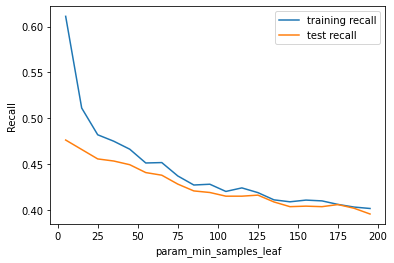

In [111]:
# Let's try optimize the min_samples_leaf to control depth of the tree
params = {'min_samples_leaf': range(5, 200, 10)}
rf = model_finetune(params)
results = rf.cv_results_
plot_the_model_performance("param_min_samples_leaf", rf, results)

From the chart above, we can see that test recall levels off at param_min_samples_leaf reach 100. We will use this level for our final model.

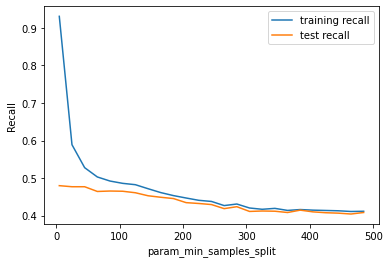

In [112]:
# Finally let's also try optimize the minimum samples in each node by tuning min_samples_split
params = {'min_samples_split': range(5, 500, 20)}
rf = model_finetune(params)
results = rf.cv_results_
plot_the_model_performance("param_min_samples_split", rf, results)

We can see that the model starts to overfit at param_min_samples_split reach 200, then continue to fall. So, we will use 200 for param_min_samples_split in our final model.

In [108]:
final_model_rf = RandomForestClassifier(bootstrap=True,
                                  max_depth=6,
                                  min_samples_leaf=100, 
                                  min_samples_split=200,
                                  n_estimators=1000,
                                  oob_score = True, n_jobs = -1,
                                  random_state =10,
                                  max_features = 20,
                                  max_leaf_nodes = 30)
final_model_rf.fit(X_train, y_train)

# Make predictions
prediction_test = final_model_rf.predict(X_test)

In [109]:
final_confusion = confusion_matrix(y_test, prediction_test)
print("Confusion Matrix:", "\n")
print(final_confusion)
print("Classification Report:", "\n")
print(classification_report(y_test, prediction_test))
print("Accuracy Score:", "\n")
print(accuracy_score(y_test, prediction_test))

Confusion Matrix: 

[[8178  129]
 [ 372  322]]
Classification Report: 

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      8307
           1       0.71      0.46      0.56       694

    accuracy                           0.94      9001
   macro avg       0.84      0.72      0.77      9001
weighted avg       0.94      0.94      0.94      9001

Accuracy Score: 

0.9443395178313521


<AxesSubplot:>

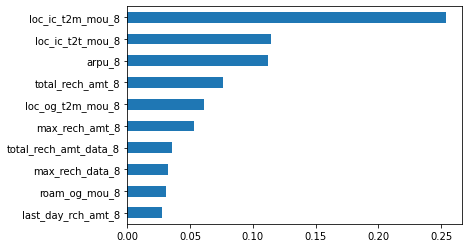

In [110]:
importances = final_model_rf.feature_importances_
weights = pd.Series(importances,
                 index=X_train.columns.values)
weights.sort_values()[-10:].plot(kind = 'barh')

## V. Insights and Recommendations

* High data imbalance between churners (8.14%) and non-churners (91.86%) makes churner predicttion a difficult task. 
* Logistic Regression model can get a recall rate of 81%, while Random Forest can only get 47%.
* Customers who have used the network for 60 months are more are less likely to churn.
* When a customer's ARPU suddenly falls below 100, it is highly likely that the user will churn. 
* The top 5 most important factors in predicting churners are all in month 8:
    * Average revenue per user in month 8 (arpu_8)
    * All kind of calls within the same operator network (onnet_mou_8)
    * All kind of calls outside the operator T network (ofnet_mou_8)
    * Indicates that customer is in roaming zone during the call (roam_ic_mou_8)
    * Indicates that customer is in roaming zone during the call (roam_og_mou_8)